# Product Data Preprocessing

## Load data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql.functions import col, length, split
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
spark = SparkSession.builder.appName("ProductDataPreprocessing").getOrCreate()

23/11/29 21:17:14 WARN Utils: Your hostname, TruongHoang resolves to a loopback address: 127.0.1.1; using 192.168.81.115 instead (on interface wlp3s0)
23/11/29 21:17:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 21:17:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option("multiline","true").json('product_tiki.json')
df.printSchema()

root
 |-- add_on: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- add_on_description: string (nullable = true)
 |    |    |-- add_on_description_list: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- add_on_information_title: string (nullable = true)
 |    |    |-- add_on_information_url: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- is_default_select_addon: long (nullable = true)
 |    |    |-- is_visible: boolean (nullable = true)
 |    |    |-- list_price: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- price: long (nullable = true)
 |    |    |-- thumbnail_url: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- add_on_title: string (nullable = true)
 |-- all_time_quantity_sold: long (nullable = true)
 |-- asa_cashback_widget: struct (nullable = true)
 |    |-- amplitude: struct (nullable = true)
 |    

In [4]:
selected_key = ["id","name","discount_rate","day_ago_created", "all_time_quantity_sold", col("categories.name").alias("category"), "rating_average", "review_count"]
df = df.select(selected_key)

In [5]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- discount_rate: long (nullable = true)
 |-- day_ago_created: long (nullable = true)
 |-- all_time_quantity_sold: long (nullable = true)
 |-- category: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- review_count: long (nullable = true)



In [6]:
df.show()

+---------+--------------------+-------------+---------------+----------------------+--------------------+--------------+------------+
|       id|                name|discount_rate|day_ago_created|all_time_quantity_sold|            category|rating_average|review_count|
+---------+--------------------+-------------+---------------+----------------------+--------------------+--------------+------------+
|235523070|LEGO SPIDEY 10789...|            0|            240|                     4|  Lắp ghép, Xếp hình|           5.0|           1|
|204421380|Set 3 quần lót bé...|            0|            354|                    14|      Đồ lót bé trai|           0.0|           0|
|202339434|Dụng Cụ Lấy Rá...|            5|            368|                    49|     Bông tắm cho bé|           4.7|           9|
|  6632811|Cháo Tươi Thịt He...|           15|           1825|                  1989|   Đồ Chơi - Mẹ & Bé|           4.7|          50|
| 10710937|Sữa bột Optimum G...|            0|         

In [7]:
df.count()

48813

In [8]:
df = df.na.drop()

In [9]:
df.count()

42459

In [10]:
df.orderBy(col("all_time_quantity_sold").desc()).show()

+---------+--------------------+-------------+---------------+----------------------+--------------------+--------------+------------+
|       id|                name|discount_rate|day_ago_created|all_time_quantity_sold|            category|rating_average|review_count|
+---------+--------------------+-------------+---------------+----------------------+--------------------+--------------+------------+
|  1559411|Phiếu Quà Tặng Ti...|            0|           2065|               1296821|   Voucher - Dịch vụ|           4.7|         426|
|  1559415|Phiếu Quà Tặng Ti...|            0|           2065|               1254838|   Voucher - Dịch vụ|           4.6|         373|
|  1559581|Phiếu Quà Tặng Ti...|            0|           2065|                889446|   Voucher - Dịch vụ|           4.5|         172|
| 75435457|Tã Quần Caryn Loạ...|           17|           1023|                786642|Tã bỉm dành cho n...|           4.8|         326|
|  7321979|Phiếu Quà Tặng Ti...|            0|         

In [11]:
import pandas as pd
df_discount_to_pd = df.select("discount_rate").toPandas()
df_daycreated_to_pd = df.select("day_ago_created").toPandas()
df_sold_to_pd = df.select("all_time_quantity_sold").toPandas()

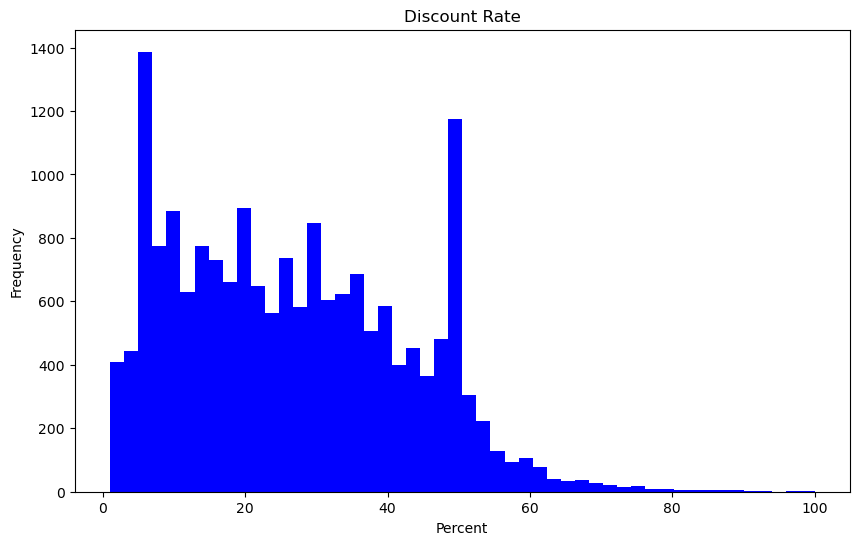

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_discount_to_pd['discount_rate'], bins=50, range=(1, 100), color='blue')
plt.xlabel('Percent')
plt.ylabel('Frequency')
plt.title('Discount Rate')
plt.show()

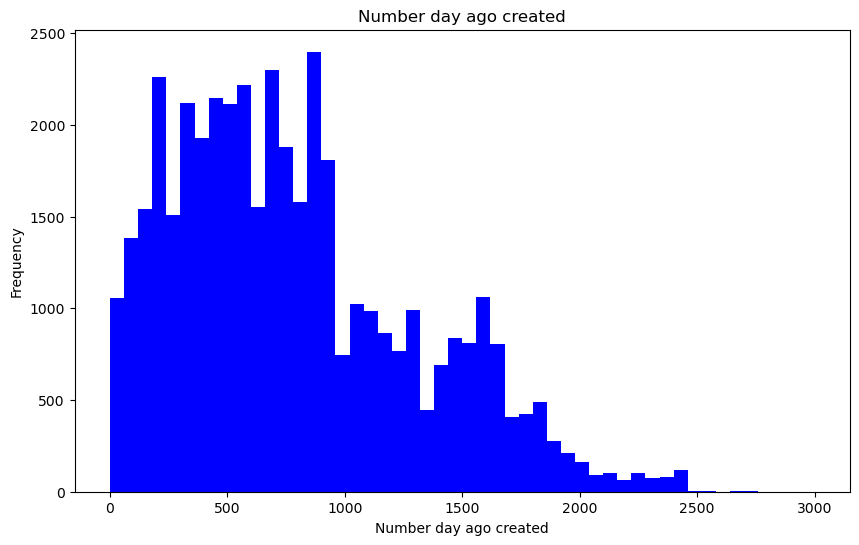

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df_daycreated_to_pd['day_ago_created'], bins=50, range=(0, 3000), color='blue')
plt.xlabel('Number day ago created')
plt.ylabel('Frequency')
plt.title('Number day ago created')
plt.show()

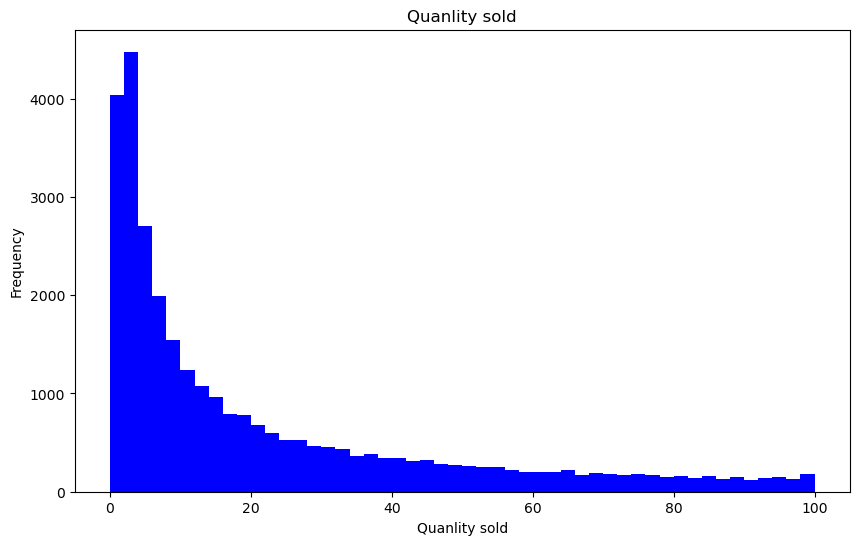

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df_sold_to_pd['all_time_quantity_sold'], bins=50,range=(0, 100), color='blue')
plt.xlabel('Quanlity sold')
plt.ylabel('Frequency')
plt.title('Quanlity sold')
plt.show()

In [15]:
output_path = "/home/truonghoang/Documents/GR2/Model/product_data_clean.csv"
df.write.csv(output_path, header=True, mode="overwrite")